# Josephson junction notebook (intentionally messy)

Messy on purpose: globals, repeated code, mixed concerns.

In [1]:
# Imports mixed with config and globals
from typing import Any, Dict, List
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as const
import kwant

a = 1.0
width = 20
mu = 0.4
delta = 0.2
t = 1.0
phases = np.linspace(0, 2*np.pi, 41)
momenta = np.linspace(-np.pi, np.pi, 121)
cache: Dict[str, Any] = {}
print('starting notebook run')

starting notebook run


In [2]:
# System builder with too many implicit assumptions
lat = kwant.lattice.square(a, norbs=2)
tau_x = np.array([[0, 1], [1, 0]], dtype=complex)
tau_y = np.array([[0, -1j], [1j, 0]], dtype=complex)
tau_z = np.array([[1, 0], [0, -1]], dtype=complex)

def make_system(w: int) -> Any:
    syst = kwant.Builder(kwant.TranslationalSymmetry((1, 0)))

    def onsite(site, phase: float, mu: float, delta: float, t: float):
        y = site.tag[1]
        local_phase = -phase / 2 if y < 0 else phase / 2
        normal = (4 * t - mu) * tau_z
        pairing = delta * np.cos(local_phase) * tau_x - delta * np.sin(local_phase) * tau_y
        return normal + pairing

    def hopping(site1, site2, t: float):
        return -t * tau_z

    syst[(lat(0, y) for y in range(-w // 2, w // 2))] = onsite
    syst[lat.neighbors()] = hopping
    return syst.finalized()


In [3]:
# One giant block for sweep + storage + plots
parameter_sets: List[Dict[str, float]] = [
    {'mu': 0.25, 'delta': 0.18, 't': 1.0, 'width': 16},
    {'mu': 0.40, 'delta': 0.20, 't': 1.0, 'width': 20},
    {'mu': 0.55, 'delta': 0.24, 't': 1.0, 'width': 24},
]
all_results: List[Dict[str, Any]] = []

for p in parameter_sets:
    s = make_system(int(p['width']))
    dispersions = []
    for phase in phases:
        # recreate bands object every phase (inefficient but clear enough for this messy notebook)
        bands = kwant.physics.Bands(
            s,
            params={'phase': float(phase), 'mu': p['mu'], 'delta': p['delta'], 't': p['t']}
        )
        energies_for_phase = []
        for k in momenta:
            energies_for_phase.append(bands(k))
        dispersions.append(np.array(energies_for_phase))

    gs = []
    for e in dispersions:
        neg = e[e < 0]
        gs.append(float(np.sum(neg)) / max(1, e.shape[0]))
    gs = np.array(gs)
    current = (2 * const.e / const.hbar) * np.gradient(gs, phases)

    all_results.append({'params': p, 'dispersions': dispersions, 'current': current})

cache['all_results'] = all_results
print('done sweep for', len(all_results), 'parameter sets')


done sweep for 3 parameter sets


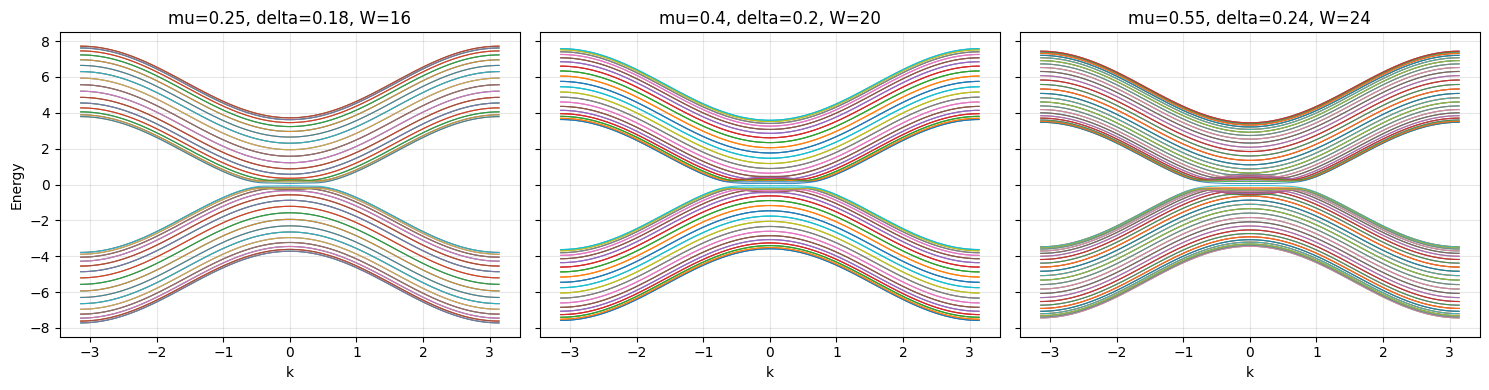

In [4]:
# Plot selected dispersion curves for each parameter set
fig, axes = plt.subplots(1, len(all_results), figsize=(5 * len(all_results), 4), sharey=True)
if len(all_results) == 1:
    axes = [axes]

targets = [0.0, np.pi / 2, np.pi]
for i, result in enumerate(all_results):
    ax = axes[i]
    for target in targets:
        idx = int(np.argmin(np.abs(phases - target)))
        ax.plot(momenta, result['dispersions'][idx], lw=0.8, alpha=0.8, label=f'phi={phases[idx]:.2f}')
    p = result['params']
    ax.set_title(f"mu={p['mu']}, delta={p['delta']}, W={int(p['width'])}")
    ax.set_xlabel('k')
    ax.grid(alpha=0.3)
axes[0].set_ylabel('Energy')
plt.tight_layout()
plt.show()

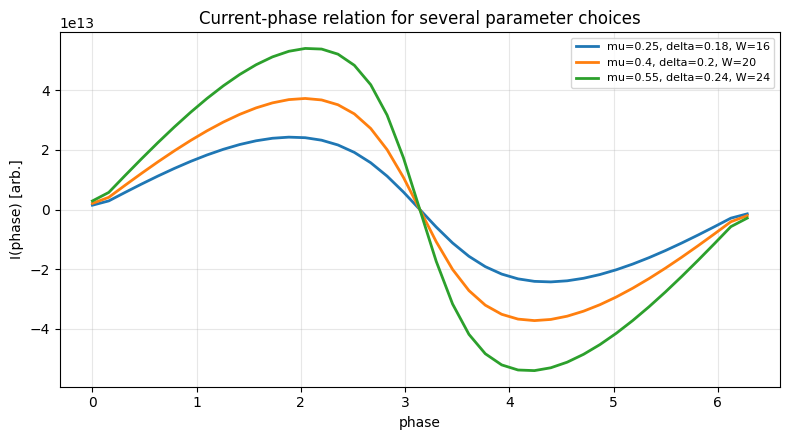

In [8]:
# Current-phase curves for all parameter sets
plt.figure(figsize=(8, 4.5))
for result in all_results:
    p = result['params']
    label = f"mu={p['mu']}, delta={p['delta']}, W={int(p['width'])}"
    plt.plot(phases, result['current'], lw=2, label=label)
plt.xlabel('phase')
plt.ylabel('I(phase) [arb.]')
plt.title('Current-phase relation for several parameter choices')
plt.grid(alpha=0.3)
plt.legend(fontsize=8)
plt.tight_layout()
plt.show()